In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pickle

# 데이터 준비
## 데이터 불러오기

In [539]:
recvae= pd.read_csv('/opt/ml/input/code/RecVAE/analysis_recvae50.csv') #유저 별 아이템 50개 추천한 csv파일
hvamp= pd.read_csv('/opt/ml/input/hvamp_output.csv')
tr= pd.read_csv('/opt/ml/input/data/train/pro_sg/check_tr.csv')
recvae10= pd.read_csv('/opt/ml/input/analysis_tr.csv') #유저 별 아이템 10개 추천한 csv 파일

In [6]:
with open('profile2id_check.pkl', 'rb') as f:
    profile2id = pickle.load(f)

with open('show2id_check.pkl', 'rb') as f:
    show2id = pickle.load(f)

In [7]:
re_p2id = dict((v, k) for k, v in profile2id.items())
re_s2id = dict((v, k) for k, v in show2id.items())

In [540]:
answer= pd.read_csv('/opt/ml/input/check_te.csv')
def de_numerize(tp, re_p2id, re_s2id):
    uid = tp['uid'].apply(lambda x: re_p2id[x])
    sid = tp['sid'].apply(lambda x: re_s2id[x])
    return pd.DataFrame(data={'uid': uid, 'sid': sid}, columns=['uid', 'sid'])

answer = de_numerize(answer, re_p2id, re_s2id)
answer.rename({'uid':'user'}, axis=1, inplace=True)
answer.rename({'sid':'item'}, axis=1, inplace=True)

In [541]:
tr = de_numerize(tr, re_p2id, re_s2id)
tr.rename({'uid':'user'}, axis=1, inplace=True)
tr.rename({'sid':'item'}, axis=1, inplace=True)

## 지표 설정
reranking의 효과를 미리 증명해보기 위한 지표를 recall@10값으로 설정했습니다.

In [9]:
# 유저별 recall 값 구하기
from tqdm import tqdm

recall_per_user = []
index_user = sorted(recvae.user.value_counts().index.values)
for x in tqdm(index_user):
    item_list = recvae[recvae.user == x].item.values
    cnt = 0
    for ele in item_list:
        if ele in answer[answer.user == x].item.values:
            cnt += 1
    recall_per_user.append(cnt / np.minimum(10, len(answer[answer.user == x])))

In [542]:
with open('recall_per_user.pkl', 'wb') as f:
    pickle.dump(recall_per_user,f)

with open('recall_per_user.pkl', 'rb') as f:
    recall_per_user= pickle.load(f)

In [3]:
lowest_result_users=  pd.read_csv('recvae_lowest_user.csv')

In [11]:
index_user = sorted(recvae.user.value_counts().index.values)

In [12]:
print('최소: ', min(recall_per_user))
print('최대: ', max(recall_per_user))
print('평균: ', np.mean(recall_per_user))

최소:  0.0
최대:  1.0
평균:  0.4086554502753482


- 원래대로 10개의 아이템을 추천한 데이터셋의 recall값은 약 0.409입니다.

## 추천이 잘 안된 유저군 추출

In [543]:
all_result = pd.DataFrame([index_user, recall_per_user]).T
all_result.columns = ['user', 'recall@10']

In [544]:
low_result = all_result[all_result['recall@10'] < 0.4]
mid_result = all_result[(all_result['recall@10'] >= 0.4) & (all_result['recall@10'] < 0.7)]
good_result = all_result[(all_result['recall@10'] >= 0.7) & (all_result['recall@10'] <= 1)]

print(len(low_result))
print(len(mid_result))
print(len(good_result))

14115
11704
5541


In [545]:
# 일단 0.15 미만 찾아보기
lowest_result = low_result[low_result['recall@10'] <= 0.15]
lowest_result.user = lowest_result.user.astype('int')
lowest_result_users = lowest_result.user.values
lowest_reco_result =recvae[recvae.user.isin(lowest_result_users)]
lowest_result_users
len(lowest_result_users)

/opt/conda/lib/python3.8/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


4737

In [546]:
lowest_result_users

array([    43,     72,     77, ..., 138456, 138459, 138470])

In [547]:
good_result.user = good_result.user.astype('int')
best_result_users = good_result.user.values
best_reco_result = recvae[recvae.user.isin(best_result_users)]

In [548]:
raw_data = pd.read_csv('/opt/ml/input/data/train/train_ratings.csv')

# 추천이 잘 안된 유저군 분석
- 편의상 추천이 잘 안된 유저군은 bad user라고 지칭하겠습니다
- recall@10이 0.1보다 낮은 유저
- 추천이 잘된 유저군 best_reco_result와 비교하며 분석하기

In [105]:
#164회 미만의 평점이력을 가진 유저들이 lowest result users에 속할 확률
a = raw_data.groupby('user').size()
b = a[a.values <np.mean(a)]
total= raw_data['user'].nunique()
print('164회 미만의 평점이력을 가진 유저들이 lowest result users에 속할 확률:', (sum(b.index.isin(lowest_result_users)) /len(b)))
print('164회 미만의 평점이력을 가진 유저들이 best result users에 속할 확률:', (sum(b.index.isin(best_result_users)) / len(b)))

164회 미만의 평점이력을 가진 유저들이 lowest result users에 속할 확률: 0.20918343195266273
164회 미만의 평점이력을 가진 유저들이 best result users에 속할 확률: 0.057514792899408286


In [18]:
low_ans= answer[answer['user'].isin(lowest_reco_result.user.unique())]
best_ans= answer[answer['user'].isin(best_reco_result.user.unique())]

In [19]:
print('recall이 낮은 유저군에서 예측한 아이템 수:', lowest_reco_result['item'].nunique())
print('recall이 낮은 유저군에서 실제 아이템 수:', low_ans.item.nunique())

recall이 낮은 유저군에서 예측한 아이템 수: 3047
recall이 낮은 유저군에서 실제 아이템 수: 6104


In [20]:
print('recall이 높은 유저군에서 예측한 아이템 수:', best_reco_result['item'].nunique())
print('recall이 높은 유저군에서 실제 아이템 수:', best_ans.item.nunique())

recall이 높은 유저군에서 예측한 아이템 수: 1932
recall이 높은 유저군에서 실제 아이템 수: 6783


- 두 유저군 모두 실제 아이템 수에 비해 훨씬 적은 수의 아이템을 추천하고 있습니다

## 가설: bad user군은 인기있는 영화를 주로 볼 것이다.

In [34]:
raw_item= raw_data.groupby('item')['time'].count()
raw_item= pd.DataFrame(raw_item)
raw_item.reset_index(inplace=True)

In [ ]:
raw_item['time'].describe()

count     6807.000000
mean       757.230939
std       1682.973090
min         27.000000
25%         90.000000
50%        197.000000
75%        610.500000
max      19699.000000
Name: time, dtype: float64

In [46]:
# [lowest]추천 아이템 평균과 비교
standard = 757
high_mean = 0
low_mean = 0
temp= low_ans.item.value_counts().index
for i,x in enumerate(temp):
    if int(raw_item[raw_item.item==x]['time'].values) < standard:
        low_mean += 1
    else:
        high_mean += 1

print(f'{standard}이상 시청 횟수인 아이템 수: ', high_mean)
print(f'{standard}보다 작은 시청 횟수인 아이템 수: ', low_mean)
print(f'{standard}이상 시청 횟수인 실제 아이템 비중: ', high_mean/(high_mean+low_mean))

757이상 시청 횟수인 아이템 수:  1448
757보다 작은 시청 횟수인 아이템 수:  4656
757이상 시청 횟수인 실제 아이템 비중:  0.23722149410222804


In [ ]:
# [best]
high_mean = 0
low_mean = 0
temp= best_ans.item.value_counts().index
for i,x in enumerate(temp):
    if int(raw_item[raw_item.item==x]['time'].values) < standard:
        low_mean += 1
    else:
        high_mean += 1

print(f'{standard}이상 시청 횟수인 아이템 수: ', high_mean)
print(f'{standard}보다 작은 시청 횟수인 아이템 수: ', low_mean)
print(f'{standard}이상 시청 횟수인 실제 아이템 비중: ', high_mean/(high_mean+low_mean))

757이상 시청 횟수인 아이템 수:  1448
757보다 작은 시청 횟수인 아이템 수:  5335
757이상 시청 횟수인 실제 아이템 비중:  0.2134748636296624


- 미세한 차이지만 bad user가 인기있는 영화를 더 많이 봤습니다. 
- 평균 이상의 평점횟수를 가진 영화에 bad user군이 더 많이 평점 매겼음을 알 수 있습니다.


-> 그러나 인기도를 rule based model의 요소로 사용하기에는 비율에 큰 차이가 없기 때문에 적용하긴 어려울 것으로 보입니다.

### Recvae 모델에서 bad user에겐 인기있는(평균시청이력 보다 높은) 영화가 추천될까?

In [47]:
## 인기있는 영화들 고르기
standard= 757

# [lowest]추천 아이템 평균과 비교
high_mean = 0
low_mean = 0
temp= lowest_reco_result.item.value_counts().index
for i,x in enumerate(temp):
    if int(raw_item[raw_item.item==x]['time'].values) < standard:
        low_mean += 1
    else:
        high_mean += 1

print(f'{standard}이상 시청 횟수인 아이템 수: ', high_mean)
print(f'{standard}보다 작은 시청 횟수인 아이템 수: ', low_mean)
print(f'{standard}이상 시청 횟수인 아이템을 추천할 확률: ', high_mean/(high_mean+low_mean))

757이상 시청 횟수인 아이템 수:  1135
757보다 작은 시청 횟수인 아이템 수:  546
757이상 시청 횟수인 아이템을 추천할 확률:  0.6751933372992267


In [48]:
# [best]추천 아이템 평균과 비교
high_mean = 0
low_mean = 0
temp= best_reco_result.item.value_counts().index
for i,x in enumerate(temp):
    if int(raw_item[raw_item.item==x]['time'].values) < standard:
        low_mean += 1
    else:
        high_mean += 1
        

print(f'{standard}이상 시청 횟수인 아이템 수: ', high_mean)
print(f'{standard}보다 작은 시청 횟수인 아이템 수: ', low_mean)
print(f'{standard}이상 시청 횟수인 아이템을 추천할 확률: ', high_mean/(high_mean+low_mean))

757이상 시청 횟수인 아이템 수:  895
757보다 작은 시청 횟수인 아이템 수:  99
757이상 시청 횟수인 아이템을 추천할 확률:  0.9004024144869215


- 실제값과는 다르게 recvae모델은 인기있는 영화를 90%의 확률로 추천하는 유저군을 잘 맞춘 유저군으로 분류하고 있습니다.
- 그렇다면 recvae에서 추천된 모든 아이템들이 실제 유저군이 소비한 아이템 중 인기있는 아이템들을 주로 추천한 것일까?
    - 그래서 평균이상의 평점을 매긴 영화들을 많이 추천했을 때 recall 값이 높게 나온걸까?
    - 만일 그렇다면 써니가 EDA해주신 것처럼 recvae역시 인기가 많은 영화들만 추천 결과로 제시하고 있는 것일 확률이 클것입니다.

In [23]:
ans= pd.DataFrame(answer.item.value_counts())
rec= pd.DataFrame(recvae.item.value_counts())

ans.reset_index(inplace=True)
rec.reset_index(inplace=True)

In [24]:
total_temp= pd.merge(ans, rec, on='index', how='left')
# total_temp.fillna(0, inplace=True)

[]

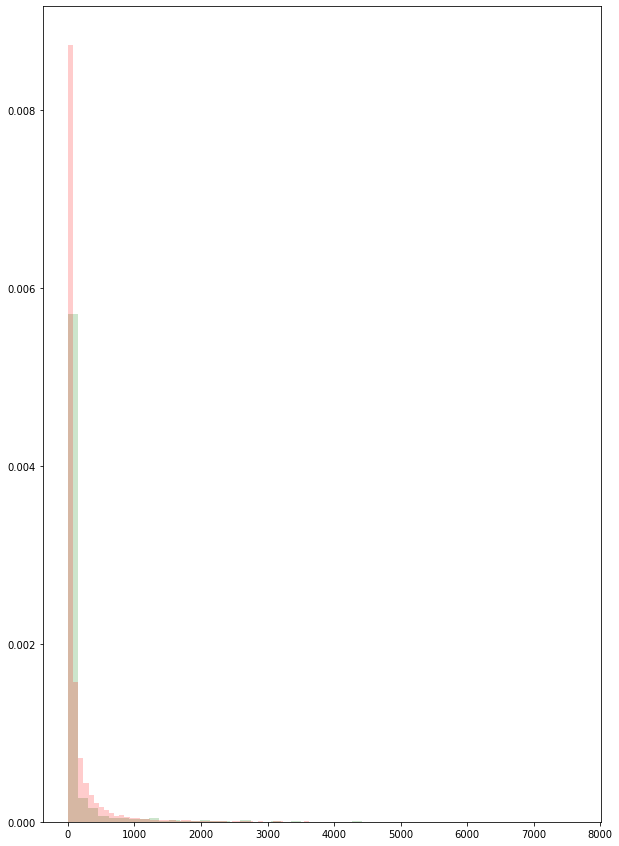

In [52]:
plt.figure(figsize=(10,15))
plt.hist(total_temp['item_y'], color = 'green', alpha = 0.2, bins = 50, label = 'best', density = True)
plt.hist(total_temp['item_x'], color = 'red', alpha = 0.2, bins = 50, label = 'original', density = True)
plt.plot()

- 예상한대로 인기있는 아이템의 경우(빨강) 모델이 해당 아이템들을 더 많이 추천(초록)하는 모습을 볼 수 있습니다.
- 그러나 극초반의 인기 아이템을 제외한 아이템들에 대해서는 추천이 잘 되지 않는 모습을 볼 수 있습니다.

# 추천이 안되는 유저와 잘되는 유저 비교 분석

In [549]:
# recvae에서 추천이 안된 아이템들 -> total_temp에서 item_y가 nan값인 애들
rec_x= total_temp[total_temp['item_y'].isna()]['index']

In [550]:
len(set(lowest_result_users))

4737

In [30]:
len(set(answer.user))

31360

lowest user에서 원래 해당 유저가 평점매긴 아이템과 추천된 아이템들의 차이를 살펴보겠습니다.

비교하기 편하도록 영화의 제목과 그 영화를 본 유저 수, 장르를 열로 추가합니다.

In [ ]:
title_data= pd.read_csv('/opt/ml/input/data/train/titles.tsv',sep='\t')
genre_data=  pd.read_csv('/opt/ml/input/data/train/genres.tsv',sep='\t')
genre_df= pd.DataFrame(genre_data.groupby('item')['genre'].apply(lambda x:[x]))
genre_df.reset_index(inplace=True)

In [552]:
dir_data= pd.read_csv('/opt/ml/input/data/train/directors.tsv',sep='\t')
dir_df= pd.DataFrame(dir_data.groupby('item')['director'].apply(lambda x:[x]))
dir_df.reset_index(inplace=True)

In [553]:
answer= pd.read_csv('/opt/ml/input/check_te.csv')
answer = de_numerize(answer, re_p2id, re_s2id)
answer.rename({'uid':'user'}, axis=1, inplace=True)
answer.rename({'sid':'item'}, axis=1, inplace=True)

In [554]:
low_answer= answer[answer.user.isin(lowest_result_users)]
low_tr= tr[tr.user.isin(lowest_result_users)]
best_answer= answer[answer.user.isin(best_result_users)]
best_tr= tr[tr.user.isin(best_result_users)]

In [555]:
num_answer= pd.DataFrame(answer.groupby('item')['user'].count()).reset_index().rename({'user':'num'}, axis=1)

low_answer= pd.merge(low_answer, title_data, on='item', how= 'left')
low_answer= pd.merge(low_answer, num_answer, on='item', how='left')
low_answer= pd.merge(low_answer, genre_df, on='item', how='left')
low_answer= pd.merge(low_answer, dir_df, on='item', how='left')

best_answer= pd.merge(best_answer, title_data, on='item', how= 'left')
best_answer= pd.merge(best_answer, num_answer, on='item', how='left')
best_answer= pd.merge(best_answer, genre_df,  on='item', how='left')
best_answer= pd.merge(best_answer, dir_df,  on='item', how='left')

low_tr= pd.merge(low_tr, title_data, on='item', how= 'left')
low_tr= pd.merge(low_tr, num_answer, on='item', how='left')
low_tr= pd.merge(low_tr, genre_df, on='item', how='left')
low_tr= pd.merge(low_tr, dir_df, on='item', how='left')

best_tr= pd.merge(best_tr, title_data, on='item', how= 'left')
best_tr= pd.merge(best_tr, num_answer, on='item', how='left')
best_tr= pd.merge(best_tr, genre_df, on='item', how='left')
best_tr= pd.merge(best_tr, dir_df, on='item', how='left')

In [556]:
lowest_reco_result0= pd.merge(lowest_reco_result, title_data, on='item', how= 'left')
lowest_reco_result0= pd.merge(lowest_reco_result0, num_answer, on='item', how='left')
lowest_reco_result0= pd.merge(lowest_reco_result0, genre_df, on='item', how='left')
lowest_reco_result0= pd.merge(lowest_reco_result0, dir_df, on='item', how='left')

best_reco_result0= pd.merge(best_reco_result, title_data, on='item', how= 'left')
best_reco_result0= pd.merge(best_reco_result0, num_answer, on='item', how='left')
best_reco_result0= pd.merge(best_reco_result0, genre_df, on='item', how='left')
best_reco_result0= pd.merge(best_reco_result0, dir_df, on='item', how='left')

In [557]:
best_reco_result0.user.unique()

array([    11,     31,    116, ..., 138472, 138486, 138493])

In [558]:
user= 138493
print(f'{user}에게 추천되어야하는 영화들:')
best_answer[best_answer.user == user].sort_values('item')


138493에게 추천되어야하는 영화들:


,user,item,title,num,genre,director
353138,138493,19,Ace Ventura: When Nature Calls (1995),418,[[Comedy]],[[nm0644203]]
353131,138493,235,Ed Wood (1994),497,"[[Comedy, Drama]]",[[nm0000318]]
353127,138493,253,Interview with the Vampire: The Vampire Chroni...,1011,"[[Drama, Horror]]",[[nm0001403]]
353135,138493,288,Natural Born Killers (1994),640,"[[Action, Crime, Thriller]]",[[nm0000231]]
353150,138493,356,Forrest Gump (1994),3447,"[[Comedy, Drama, Romance, War]]",[[nm0000709]]
...,...,...,...,...,...,...
353167,138493,52975,Hairspray (2007),149,"[[Comedy, Drama, Musical]]",[[nm0788202]]
353147,138493,53123,Once (2006),287,"[[Drama, Musical, Romance]]",[[nm0138809]]
353142,138493,53322,Ocean's Thirteen (2007),435,"[[Crime, Thriller]]",[[nm0001752]]
353184,138493,68319,X-Men Origins: Wolverine (2009),285,"[[Action, Sci-Fi, Thriller]]",[[nm0004303]]


In [559]:
print(f'학습에 사용된 {user}의 평가이력:')
best_tr[best_tr.user == user].sort_values('item')

학습에 사용된 138493의 평가이력:


,user,item,title,num,genre,director
1423618,138493,1,Toy Story (1995),2358,"[[Adventure, Animation, Children, Comedy, Fant...",[[nm0005124]]
1423729,138493,2,Jumanji (1995),648,"[[Adventure, Children, Fantasy]]",[[nm0002653]]
1423582,138493,18,Four Rooms (1995),187,[[Comedy]],"[[nm0000233, nm0001675, nm0005062]]"
1423543,138493,70,From Dusk Till Dawn (1996),473,"[[Action, Comedy, Horror, Thriller]]",[[nm0001675]]
1423530,138493,107,Muppet Treasure Island (1996),169,"[[Adventure, Children, Comedy, Musical]]",[[nm0005008]]
...,...,...,...,...,...,...
1423734,138493,61160,Star Wars: The Clone Wars (2008),61,"[[Action, Adventure, Animation, Sci-Fi]]",NaN
1423603,138493,65682,Underworld: Rise of the Lycans (2009),82,"[[Action, Fantasy, Horror, Thriller]]",NaN
1423509,138493,66762,Paris (2008),17,"[[Comedy, Drama, Romance]]",[[nm0458251]]
1423701,138493,68954,Up (2009),1291,"[[Adventure, Animation, Children, Drama]]",[[nm0230032]]


In [ ]:
print('맞춘 영화:')
print(set(best_answer[best_answer.user ==user].item) & set(best_reco_result0[best_reco_result0.user == user].item))
print(f'예측된 {user}의 평점 이력:')
best_reco_result0[best_reco_result0.user == user].sort_values('item')


In [351]:
lowest_reco_result.user.unique()[:20]

array([ 43,  72,  77,  91, 102, 163, 182, 189, 201, 204, 220, 312, 313,
       316, 351, 375, 379, 383, 395, 455])

In [ ]:
# user 별 분석
user= 379
print(f'{user}의 답안:')
low_answer[low_answer.user == user].sort_values('item')


In [ ]:
print(f'{user}가 본 학습 평가이력:')
low_tr[low_tr.user == user].sort_values('item')

In [ ]:
print('맞춘 영화:')
print(set(low_answer[low_answer.user ==user].item) & set(lowest_reco_result0[lowest_reco_result0.user == user].item))
print(f'예측된 {user}의 평점 이력:')
lowest_reco_result0[lowest_reco_result0.user == user].sort_values('item')

[평가이력수]
- best user 그룹의 평가이력은 bad user 그룹의 평가이력 수보다 대체적으로 더 많은 것을 알 수 있습니다. 
    - 즉 user가 선호할만한 영화에 대한 feature값이 잘 학습될 확률이 큽니다. 
    - 그러나 일부 bad user는 학습할만한 데이터가 많지 않기 때문에 적합한 영화를 추천하지 못했을 것입니다. 
    
-> 임베딩값에 노이즈를 넣어 해당 유저들의 아이템 수를 늘리거나, 아이템 임베딩 값에서 유사한 영화들을 추가해 학습데이터 양을 늘리면 성능향상에 도움이 되지 않을까요?

- 유저 1384565과 같이 bad user에 평가이력이 많더라도 여러 장르의 영화를 즐겨보거나 drama와 같은 범용적인 장르의 영화를 즐겨보는 유저의 경우 추천 성능이 떨어집니다.
    - 이와 유사하게 best user에서 평가이력이 상대적으로 적더라도 하나의 장르 영화를 즐겨본 유저의 경우엔 추천 성능이 좋다는 것을 발견했습니다.

->drama장르와 같이 범용적인 장르의 영화를 랜덤으로 빼줄 수 있지 않을까?

- bad user 그룹은 맞춰봤자 1개 내외의 영화를 맞추고 있음을 알 수 있습니다.

[장르]
- 대체적으로 장르의 경우 답안을 따라가는 경향이 있습니다. 
    - 코미디, 로맨스 많이 본 사람한테 그러한 장르의 영화를 추천해줌
    - 특히 유저 77,163과 같이 horror와 thriller같은 장르를 많이 봤으면 대다수를 그와 관련한 영화로 추천하는 경향이 있음
-> 영화별 유사도를 기반으로 유저가 볼 것 같은 영화후보군을 reranking하는 방법도 좋을것같습니다.

[인기도]
- 인기도가 떨어지는(평균 이하의 빈도수를 가진)영화도 가끔 추천결과로 나오지만 대체적으로 num이 큰 영화들이 결과로 제시됩니다.
    

# 유사도 기반 reranking

In [234]:
from gensim.models import Word2Vec
model = Word2Vec.load('/opt/ml/input/code/RecVAE/item2vec_word2vecSg_20180328')
word_vectors = model.wv

In [ ]:
answer= pd.read_csv('/opt/ml/input/check_te.csv')
def de_numerize(tp, re_p2id, re_s2id):
    uid = tp['uid'].apply(lambda x: re_p2id[x])
    sid = tp['sid'].apply(lambda x: re_s2id[x])
    return pd.DataFrame(data={'uid': uid, 'sid': sid}, columns=['uid', 'sid'])

answer = de_numerize(answer, re_p2id, re_s2id)
answer.rename({'uid':'user'}, axis=1, inplace=True)
answer.rename({'sid':'item'}, axis=1, inplace=True)

In [601]:
# inference시 실행
recvae7=pd.read_csv('/opt/ml/input/code/RecVAE/recvae_dir_genre7.csv')
recvae7_50=pd.read_csv('/opt/ml/input/code/RecVAE/recvae_dir_genre7_50.csv')

In [602]:
# inference시 실행
lowest_reco_result0= recvae7_50[recvae7_50.user.isin(lowest_result_users)]
low_tr= pd.read_csv('/opt/ml/input/data/train/train_ratings.csv') # 학습에 사용된 전체 데이터셋

In [645]:
import torch
from sklearn.metrics import pairwise_distances
from collections import Counter

recvae= torch.load('/opt/ml/input/code/RecVAE/recvae7.pt')
emb= recvae.decoder.weight
emb= emb.detach().cpu().numpy()
sim= 1-pairwise_distances(emb, metric="cosine")

# 자기자신 제외
sim[sim == 1]= -np.inf

with open('profile2id_check.pkl', 'rb') as f:
    profile2id = pickle.load(f)

with open('show2id_check.pkl', 'rb') as f:
    show2id = pickle.load(f)
re_p2id = dict((v, k) for k, v in profile2id.items())
re_s2id = dict((v, k) for k, v in show2id.items())

In [604]:
dir_pref= np.load('/opt/ml/input/data/train/pref_item0.npy') #numerize, 유저별 특정 감독의 영화에 대한 선호도
dir_pref[dir_pref==2] = 10
genre_pref= np.load("/opt/ml/input/data/train/lst.npy")

# 감독선호도와 장르선호도를 reranking에 반영하는 함수
def reflect_pref(dic, dic2):
    key= dic.keys()
    for k in key:
        dic[k] *= dir_pref[profile2id[user]][show2id[k]] # 감독선호
        dic[k] += genre_pref[profile2id[user]][show2id[k]] # 장르선호

    key2= dic2.keys()
    for k in key2:
        dic2[k] *= dir_pref[profile2id[user]][show2id[k]] # 감독선호
        dic2[k] += genre_pref[profile2id[user]][show2id[k]] # 장르선호
    
    return dic,dic2

# 영화 간 유사도를 기반으로 아이템을 재추천해주는 함수
def similarities(user, reflect=True):
    low_tr_item= low_tr[low_tr.user == user]['item']
    rec_item= lowest_reco_result0[lowest_reco_result0.user==user]['item']

    low_tr_item2= low_tr[low_tr.user == user]['item'].apply(lambda x: show2id[x]) #recvae sim적용위한 numerize
    rec_item2= lowest_reco_result0[lowest_reco_result0.user==user]['item'].apply(lambda x: show2id[x])

    leng= len(low_tr_item)
    rec_l= len(rec_item)
    if leng > rec_l:
        sim_df= pd.DataFrame(data={'low_tr':list(low_tr_item.sort_values()), 'rec_item': list(rec_item.sort_values()) + [7000] * abs(leng-rec_l)})
    elif leng < rec_l:
        sim_df= pd.DataFrame(data={'low_tr':list(low_tr_item.sort_values())+ [7000] * abs(leng-rec_l), 'rec_item': list(rec_item.sort_values())})
    else:
        sim_df= pd.DataFrame(data={'low_tr':list(low_tr_item.sort_values()), 'rec_item': list(rec_item.sort_values())})

    leng2= len(low_tr_item2)
    rec_l2= len(rec_item2)
    if leng2 > rec_l2:
        sim_df2= pd.DataFrame(data={'low_tr':list(low_tr_item2.sort_values()), 'rec_item': list(rec_item2.sort_values()) + [7000] * abs(leng2-rec_l2)})
    elif leng2 < rec_l2:
        sim_df2= pd.DataFrame(data={'low_tr':list(low_tr_item2.sort_values())+ [7000] * abs(leng2-rec_l2), 'rec_item': list(rec_item2.sort_values())})
    else:
        sim_df2= pd.DataFrame(data={'low_tr':list(low_tr_item2.sort_values()), 'rec_item': list(rec_item2.sort_values())})

    sim_df['sim']=0
    sim_df2['sim']=0

    sim_pivot= sim_df.pivot_table(index='low_tr', columns='rec_item', values='sim')
    sim_pivot2= sim_df2.pivot_table(index='low_tr', columns='rec_item', values='sim')
    if sum([7000 in sim_pivot.index]) >=1:
        sim_pivot.drop(7000, axis=0, inplace=True)
    elif sum([7000 in sim_pivot.columns]) >=1:
        sim_pivot.drop(7000, axis=1, inplace=True)

    if sum([7000 in sim_pivot2.index]) >=1:
        sim_pivot2.drop(7000, axis=0, inplace=True)
    elif sum([7000 in sim_pivot2.columns]) >=1:
        sim_pivot2.drop(7000, axis=1, inplace=True)

        
    idx=list(sim_pivot.index)
    dic={}
    for col in sim_pivot.columns:
        for idx in sim_pivot.index:
            try: 
                sim_pivot[col][idx]= word_vectors.similarity(str(col),str(idx))
            except:
                sim_pivot[col][idx]= 0

        dic[col]= sim_pivot[col].sum()

    dic2={}
    idx2=list(sim_pivot2.index)
    for col in sim_pivot2.columns:
        sim_pivot2[col]=sim[col][idx2]
        dic2[re_s2id[col]]= sim_pivot2[col].sum() # denum
    

    if reflect==True:
        dic, dic2= reflect_pref(dic,dic2)
    dic3= Counter(dic2) + Counter(dic)
    temp= sorted(dic3.items(), key = lambda item: item[1], reverse=True)[:10] # 원래 아이디
    items= list(map(lambda x:x[0], temp))

    return user, items

In [605]:
user2 = []
item2 = []
for u in tqdm(lowest_reco_result.user.unique()):
    user, items = similarities(u, reflect=True)
    user2.extend([user]*10)
    item2.extend(items)

100%|██████████| 4737/4737 [32:17<00:00,  2.45it/s] 


In [621]:
u2 = pd.DataFrame(user2, columns=['user'])
i2 = pd.DataFrame(item2, columns=['item'])
all2 = pd.concat([u2, i2], axis=1)

In [622]:
all2

,user,item
0,43,4995
1,43,5989
2,43,4886
3,43,2762
4,43,7153
...,...,...
47365,138470,48516
47366,138470,3897
47367,138470,4878
47368,138470,48774


reranking을 진행하지 않은 best, middle 유저군과 합쳐 결과파일 생성

In [609]:
sub= recvae7[recvae7.user.isin(lowest_reco_result.user.unique())].index
recvae7.drop(sub, axis=0, inplace=True)
final= pd.concat([recvae7, all2], axis=0)

In [579]:
final.to_csv('recvae_low_process2.csv')